In [22]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
K = 64 # number of OFDM subcarriersv
CP = K//4  # length of the cyclic prefix: 25% of the block
P = 10 # number of pilot carriers per OFDM block
pilotValue = 3+3j # The known value each pilot transmits
allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])
pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.
# For convenience of channel estimation, let's make the last carriers also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
print(pilotCarriers)
P = P+1
# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)
mu = 2 # bits per symbol
payloadBits_per_OFDM = len(dataCarriers)*mu  # number of payload bits per OFDM symbol
# mapping_table = {
#     (0,0,0) : 0,
#     (0,0,1) : np.cos(np.pi/4)+np.sin(np.pi/4)*1j,
#     (0,1,0) : np.cos(2*np.pi/4)+np.sin(2*np.pi/4)*1j,
#     (0,1,1) : np.cos(3*np.pi/4)+np.sin(3*np.pi/4)*1j,
#     (1,0,0) : np.cos(4*np.pi/4)+np.sin(4*np.pi/4)*1j,
#     (1,0,1) : np.cos(5*np.pi/4)+np.sin(5*np.pi/4)*1j,
#     (1,1,0) : np.cos(6*np.pi/4)+np.sin(6*np.pi/4)*1j,
#     (1,1,1) : np.cos(7*np.pi/4)+np.sin(7*np.pi/4)*1j}
mapping_table = {
     (0,0) : 0+0*1j,
     (0,1) : np.cos(np.pi/2)+np.sin(np.pi/2)*1j,
     (1,0) : np.cos(np.pi)+np.sin(np.pi)*1j,
     (1,1) : np.cos(3*np.pi/2)+np.sin(3*np.pi/2)*1j,
 }
demapping_table = {v : k for k, v in mapping_table.items()}
channelResponse = np.array([1, 0, 0.09+0.04j])  # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, K)

#serial to parallel
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))

def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning
def channel(signal):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
    #print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise
def removeCP(signal):
    return signal[CP:(CP+K)]
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)

def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)

    return Hest

def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest
def get_payload(equalized):
    return equalized[dataCarriers]
def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])

    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))

    # for each element in QAM, choose the index in constellation
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)

    # get back the real constellation point
    hardDecision = constellation[const_index]

    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision
def PS(bits):
    return bits.reshape((-1,))

[ 0  6 12 18 24 30 36 42 48 54 60 63]


In [24]:
def encode_bits(input_bits, g1, g2):
    state = 0  # Initial state
    encoded_bits = []

    for bit in input_bits:
        g1_output = (bit ^ (state >> 1) ^ (state & 1))  # g1 output
        g2_output = (bit ^ (state & 1))                  # g2 output
        encoded_bits.append(g1_output)
        encoded_bits.append(g2_output)

        # Update state (shift left and append the new input bit)
        state = ((state << 1) & (len(g1) - 1)) | bit
    # Handle remaining states with 0 inputs
    for _ in range(len(g1) - 1):
        g1_output = (0 ^ (state >> 1) ^ (state & 1))
        g2_output = (0 ^ (state & 1))
        encoded_bits.append(g1_output)
        encoded_bits.append(g2_output)

    return encoded_bits

# 450838
bits = data_bits = np.random.randint(0, 2,716038)
g1 = [1, 1, 0]
g2 = [1, 0, 1]

coded_bits = encode_bits(bits, g1, g2)

In [7]:
def viterbi_decoder(encoded_bits, g1, g2):
    n_states = 2 ** (len(g1) - 1)  # Number of states
    n_output_bits = len(encoded_bits) // 2  # Each input bit produces two output bits

    # Initialize the trellis and path metrics
    trellis = np.zeros((n_states, n_output_bits + 1), dtype=int)  # Store state path
    path_metrics = np.full((n_states, n_output_bits + 1), np.inf)  # Initialize path metrics
    path_metrics[0, 0] = 0  # Start at state 0

    # Build the trellis
    for i in range(n_output_bits):
        for current_state in range(n_states):
            for input_bit in [0, 1]:
                # Calculate the next state
                next_state = ((current_state << 1) & (n_states - 1)) | input_bit

                # Calculate expected outputs based on the current state and input bit
                g1_output = (input_bit ^ ((current_state >> 1) & 1) ^ (current_state & 1))  # g1 output
                g2_output = (input_bit ^ (current_state & 1))                                  # g2 output

                # Construct the expected output
                expected_output = np.array([g1_output, g2_output])

                # Calculate the Hamming distance
                actual_output = encoded_bits[i * 2:i * 2 + 2]
                hamming_distance = np.sum(np.abs(expected_output - actual_output))

                # Update path metrics
                new_metric = path_metrics[current_state, i] + hamming_distance
                if new_metric < path_metrics[next_state, i + 1]:
                    path_metrics[next_state, i + 1] = new_metric
                    trellis[next_state, i + 1] = current_state  # Record the path

    # Backtrack to find the best path
    best_path = []
    # Find the state with the minimum path metric at the last column
    min_state = np.argmin(path_metrics[:, n_output_bits])
    for i in range(n_output_bits, 0, -1):
        best_path.append(min_state)
        min_state = trellis[min_state, i]
    best_path.reverse()

    # Convert the best path states back to input bits
    decoded_bits = [(state & 1) for state in best_path]
    return decoded_bits


In [25]:
coded_bits = encode_bits(bits, g1, g2)
coded_bits=np.array(coded_bits)
SNRdb=22
QAM_est=[]
for i in range(0,len(coded_bits),payloadBits_per_OFDM):
  ofdm_sym=coded_bits[i:i+payloadBits_per_OFDM]
  bits_SP = SP(ofdm_sym)
  QAM = Mapping(bits_SP)
  OFDM_data = OFDM_symbol(QAM)
  OFDM_time = IDFT(OFDM_data)
  OFDM_withCP = addCP(OFDM_time)
  OFDM_TX = OFDM_withCP
  #channel
  OFDM_RX = channel(OFDM_TX)
  #receiver
  OFDM_RX_noCP = removeCP(OFDM_RX)
  OFDM_demod = DFT(OFDM_RX_noCP)
  Hest = channelEstimate(OFDM_demod)
  equalized_Hest = equalize(OFDM_demod, Hest)
  QAM_est.append(get_payload(equalized_Hest))
combined_arr = np.concatenate(QAM_est)
QAM_est= combined_arr.tolist()
QAM_est=np.array(QAM_est)
PS_est, hardDecision = Demapping(QAM_est)
pre_decod_bits_est = PS(PS_est)
decoded_bits = viterbi_decoder(pre_decod_bits_est, g1, g2)
decoded_bits=decoded_bits[:-2]
np.sum((decoded_bits^bits))/len(bits)

2.793147849695128e-06

In [ ]:
 #use for only one SNR
BER=[]
for SNRdb in np.arange(0, 23, 2):
  bits=np.random.binomial(n=1, p=0.5, size=(716038, ))
  coded_bits = encode_bits(bits, g1, g2)
  coded_bits=np.array(coded_bits)
  QAM_est=[]
  for i in range(0,len(coded_bits),payloadBits_per_OFDM):

    ofdm_sym=coded_bits[i:i+payloadBits_per_OFDM]
    bits_SP = SP(ofdm_sym)
    QAM = Mapping(bits_SP)
    OFDM_data = OFDM_symbol(QAM)
    OFDM_time = IDFT(OFDM_data)
    OFDM_withCP = addCP(OFDM_time)
    OFDM_TX = OFDM_withCP
  #channel
    convolved = np.convolve(OFDM_TX, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    OFDM_RX =convolved + noise
    OFDM_RX_noCP = removeCP(OFDM_RX)
    OFDM_demod = DFT(OFDM_RX_noCP)
    Hest = channelEstimate(OFDM_demod)
    equalized_Hest = equalize(OFDM_demod, Hest)
    QAM_est.append(get_payload(equalized_Hest))
  combined_arr = np.concatenate(QAM_est)
  QAM_est= combined_arr.tolist()
  QAM_est=np.array(QAM_est)
  PS_est, hardDecision = Demapping(QAM_est)
  pre_decod_bits_est = PS(PS_est)
  decoded_bits = viterbi_decoder(pre_decod_bits_est, g1, g2)
  decoded_bits=decoded_bits[:-2]
  BER.append(np.sum((decoded_bits^bits))/len(bits))
  print(BER(SNRdb))

In [26]:

BER=[]
for SNRdb in np.arange(1, 23, 1):
  bits=np.random.binomial(n=1, p=0.5, size=(716038, ))
  coded_bits = encode_bits(bits, g1, g2)
  coded_bits=np.array(coded_bits)
  QAM_est=[]
  for i in range(0,len(coded_bits),payloadBits_per_OFDM):

    ofdm_sym=coded_bits[i:i+payloadBits_per_OFDM]
    bits_SP = SP(ofdm_sym)
    QAM = Mapping(bits_SP)
    OFDM_data = OFDM_symbol(QAM)
    OFDM_time = IDFT(OFDM_data)
    OFDM_withCP = addCP(OFDM_time)
    OFDM_TX = OFDM_withCP
  #channel
    convolved = np.convolve(OFDM_TX, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    OFDM_RX =convolved + noise
    OFDM_RX_noCP = removeCP(OFDM_RX)
    OFDM_demod = DFT(OFDM_RX_noCP)
    Hest = channelEstimate(OFDM_demod)
    equalized_Hest = equalize(OFDM_demod, Hest)
    QAM_est.append(get_payload(equalized_Hest))
  combined_arr = np.concatenate(QAM_est)
  QAM_est= combined_arr.tolist()
  QAM_est=np.array(QAM_est)
  PS_est, hardDecision = Demapping(QAM_est)
  pre_decod_bits_est = PS(PS_est)
  decoded_bits = viterbi_decoder(pre_decod_bits_est, g1, g2)
  decoded_bits=decoded_bits[:-2]
  BER.append(np.sum((decoded_bits^bits))/len(bits))
  print(BER(SNRdb))

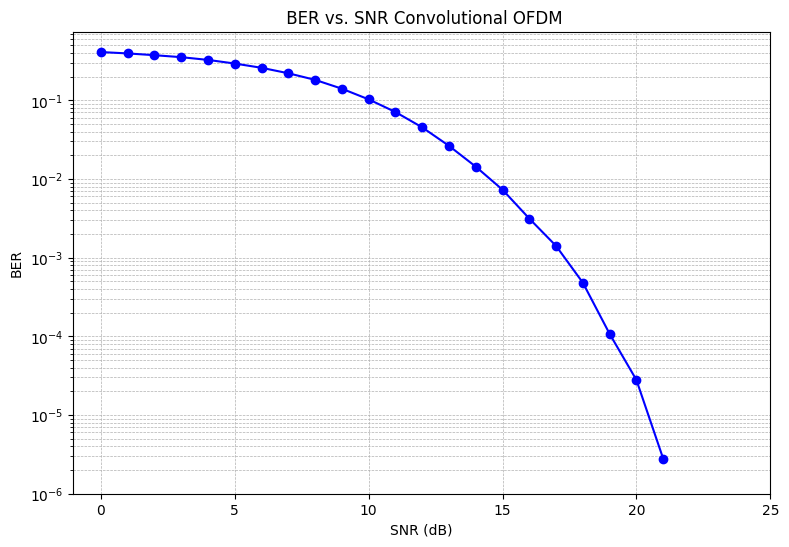

In [36]:

# Given SNR values and corresponding BER values
SNRdb = np.arange(0, 22, 1)  # SNR from 0 to 32 in steps of 2
ber1=BER[1:]
# Create a semilogy plot
plt.figure(figsize=(9, 6))
plt.semilogy(SNRdb, ber1, marker='o', linestyle='-', color='b')
plt.title(' BER vs. SNR Convolutional OFDM')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks([0,5,10,15,20,25])  # Set x-ticks to the SNR values
plt.ylim(bottom=1e-6)  # Set a lower limit for the y-axis to enhance visibility
plt.show()